In [1]:
import pandas as pd
import numpy as np

import lightgbm as lgb
import catboost as cbt

import datetime

from sklearn.preprocessing import LabelEncoder
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import sys
sys.path.insert(0, 'IEEE_FRAUD')

In [3]:
identity_cols = !head -1 data/train_identity.csv
identity_cols = identity_cols[0].split(',')

In [4]:
%%time
folder_path = 'data/'
train = pd.read_pickle(f'{folder_path}train.pkl')
test = pd.read_pickle(f'{folder_path}test.pkl')

CPU times: user 1.74 s, sys: 3.72 s, total: 5.46 s
Wall time: 27.6 s


In [5]:
N_TRAIN_EXAMPLES = len(train)

In [6]:
tr_am = pd.read_csv(f'{folder_path}train_transaction.csv', usecols=['TransactionAmt'], dtype=str)
te_am = pd.read_csv(f'{folder_path}test_transaction.csv', usecols=['TransactionAmt'], dtype=str)
train[['dollars', 'cents']] = tr_am.TransactionAmt.str.split('.', expand=True).astype(int)
test[['dollars', 'cents']] = te_am.TransactionAmt.str.split('.', expand=True).astype(int)

In [7]:
roman_df = pd.read_pickle('new_roman_features.pkl')

In [8]:
roman_df.reset_index(drop=True, inplace=True)
roman_df.set_index('index', inplace=True)

In [9]:
roman_df.drop(labels=['is_foreign', 'is_holiday'], inplace=True, axis=1)

In [10]:
roman_feature_names = set(roman_df.columns.to_list())

In [11]:
MODEL_FEATURES = set(test.columns) - set(['TransactionDT', 'TransactionID'])

In [12]:
basic_features = set(test.columns) - set(['TransactionDT', 'TransactionID'])

In [13]:
CATEGORICAL_FEATURES =  set(['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19',
            'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
            'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37',
            'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4','P_emaildomain',
            'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2', 
            'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9'])

Говорят, что неплохо бы дропнуть те карты, которые не встречается или в трейне, или в тесте

In [16]:
for col in ['card1']: 
    valid_card = pd.concat([train[[col]], test[[col]]])
    valid_card_std = valid_card.values.std()

    invalid_cards = valid_card[valid_card <= 2]
    print('Rare cards',len(invalid_cards))

    valid_card = valid_card[valid_card > 2]
    valid_card = list(valid_card.index)

    print('No intersection in Train', len(train[~train[col].isin(test[col])]))
    print('Intersection in Train', len(train[train[col].isin(test[col])]))
    
    train[col] = np.where(train[col].isin(test[col]), train[col], np.nan)
    test[col]  = np.where(test[col].isin(train[col]), test[col], np.nan)

    train[col] = np.where(train[col].isin(valid_card), train[col], np.nan)
    test[col]  = np.where(test[col].isin(valid_card), test[col], np.nan)
    print('#'*20)

for col in ['card2','card3','card4','card5','card6',]: 
    print('No intersection in Train', col, len(train[~train[col].isin(test[col])]))
    print('Intersection in Train', col, len(train[train[col].isin(test[col])]))
    
    train[col] = np.where(train[col].isin(test[col]), train[col], np.nan)
    test[col]  = np.where(test[col].isin(train[col]), test[col], np.nan)
    print('#'*20)

Rare cards 1097231
No intersection in Train 10396
Intersection in Train 580144
####################
No intersection in Train card2 5012
Intersection in Train card2 585528
####################
No intersection in Train card3 47
Intersection in Train card3 590493
####################
No intersection in Train card4 0
Intersection in Train card4 590540
####################
No intersection in Train card5 7279
Intersection in Train card5 583261
####################
No intersection in Train card6 30
Intersection in Train card6 590510
####################


In [17]:
all_df = pd.concat([train, test])
all_df = pd.concat([all_df, roman_df], axis=1)

# Фичи по датам

In [18]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

dates_range = pd.date_range(start='2017-10-01', end='2019-01-01')
us_holidays = calendar().holidays(start=dates_range.min(), end=dates_range.max())

In [19]:
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')


In [20]:
del train, test, roman_df

In [21]:
import gc

In [22]:
gc.collect()

3920

In [23]:
def datetime_features(all_df):
    all_df['DT'] = all_df['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
    all_df['dayofweek'] = all_df['DT'].dt.dayofweek
    all_df['dayofmonth'] = all_df['DT'].dt.day
    all_df['hour'] = all_df['DT'].dt.hour
    all_df['weekofmonth'] = (all_df['DT'].dt.day - 1) // 7 + 1
    #all_df['is_holiday'] = (all_df['DT'].dt.date.astype('datetime64').isin(us_holidays)).astype(np.int8)
    new_features = ['dayofweek', 'dayofmonth', 'hour', 'weekofmonth']#, 'is_holiday']
    return new_features, new_features

In [24]:
%%time
a, c = datetime_features(all_df)
MODEL_FEATURES.update(a)
CATEGORICAL_FEATURES.update(c)

CPU times: user 1.43 s, sys: 36 ms, total: 1.46 s
Wall time: 1.46 s


In [25]:
all_df['DT_split'] = (all_df['DT'].dt.year - 2017) * 12 + all_df['DT'].dt.month
N_TRAIN = sum(all_df['DT_split'] < 17)

In [26]:
all_df['day'] = ((all_df['DT'].dt.year-2017)*365 + all_df['DT'].dt.dayofyear).astype(np.int16)
all_df['hour_day'] = all_df['DT'].dt.hour + 24 * (all_df['day'] - 335)

# D-features

In [27]:
d_cols = [col for col in all_df.columns if col.startswith('D') and not col[-1:].isalpha() and col != 'D9']

In [28]:
d_cols

['D1',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8']

In [29]:
d_cols_notnull = [d + '_notnull' for d in d_cols + ['D9']]
all_df[d_cols_notnull] = all_df[d_cols + ['D9']].notnull()

In [30]:
# Lets transform D8 and D9 column
# As we almost sure it has connection with hours
all_df['D8_not_same_day'] = np.where(all_df['D8']>=1,1,0)
all_df['D8_D9_decimal_dist'] = all_df['D8'].fillna(0)-all_df['D8'].fillna(0).astype(int)
all_df['D8_D9_decimal_dist'] = ((all_df['D8_D9_decimal_dist']-all_df['D9'])**2)**0.5
all_df['D8'] = all_df['D8'].fillna(-1).astype(int)

In [31]:
MODEL_FEATURES.update(['D8_not_same_day', 'D8_D9_decimal_dist', 'D8_D9_decimal_dist'])

In [32]:
def values_normalization(all_df, period, col, clip=True, minmax=True):
        new_col = col + '_' + period
        df = all_df[[col, period]].copy()
        df[col] = df[col].astype(float)
        if clip:
            df[col] = df[col].clip(0) 

        aggs = df.groupby([period])[col].agg(['min', 'max', 'std', 'mean'])
        
        agg_max = aggs['max'].to_dict()
        agg_min = aggs['min'].to_dict()
        agg_std = aggs['std'].to_dict()
        agg_mean = aggs['mean'].to_dict()

        all_df['temp_min'] = all_df[period].map(agg_max)
        all_df['temp_max'] = all_df[period].map(agg_min)
        all_df['temp_std'] = all_df[period].map(agg_std)
        all_df['temp_mean'] = all_df[period].map(agg_mean)
        

        all_df[new_col + '_min_max'] = ((all_df[col] - all_df['temp_min']) /\
                (all_df['temp_max'] - all_df['temp_min'])).astype(float)
        
        all_df[new_col + '_std_score'] = (all_df[col] - all_df['temp_mean']) / (all_df['temp_std'])

        del all_df['temp_min'], all_df['temp_max'], all_df['temp_std'], all_df['temp_mean']

In [33]:
%%time
for period in ['day']:
    for col in d_cols:
        values_normalization(all_df, period, col, minmax=True)

CPU times: user 23.7 s, sys: 31.3 s, total: 55 s
Wall time: 55 s


In [34]:
for col in ['D1','D2']:
    all_df[col + '_scaled'] = all_df[col] / all_df[:N_TRAIN_EXAMPLES][col].max()

In [35]:
MODEL_FEATURES.update(['D1_scaled', 'D2_scaled'])

# E-mail features

In [ ]:
def mail_split_features(df):
    p_domain = ['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']
    r_domain = ['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']
    all_df[p_domain] =\
        all_df['P_emaildomain'].str.split('.', expand=True)
    all_df[r_domain] =\
        all_df['P_emaildomain'].str.split('.', expand=True)
    return p_domain + r_domain, p_domain + r_domain
    

In [ ]:
%%time
a, c = mail_split_features(all_df)
MODEL_FEATURES.update(a)
CATEGORICAL_FEATURES.update(c)

# Device info

In [36]:
all_df['DeviceInfo'].fillna('', inplace=True)
all_df['id_30'].fillna('', inplace=True)
all_df['id_31'].fillna('', inplace=True)

In [ ]:
def add_device_features(all_df):
    all_df['DeviceInfoMajor'] = all_df['DeviceInfo'].str.split(' ', expand=True)[0]
    all_df['DeviceInfoTop'] = all_df['DeviceInfo'].str.split('-', expand=True)[0]
    all_df['DeviceInfoIsRV'] = all_df['DeviceInfoMajor'].apply(lambda x: 'rv' in x)
    return ['DeviceInfoMajor', 'DeviceInfoTop', 'DeviceInfoIsRV'], ['DeviceInfoMajor', 'DeviceInfoTop']

In [ ]:
%%time
a, c = add_device_features(all_df)
MODEL_FEATURES.update(a)
CATEGORICAL_FEATURES.update(c)

In [ ]:
def split_version(version):
    n_sep_a = version.count('.')
    n_sep_b = version.count('_')
    if n_sep_a > 0:
        return version.split('.')[0]
    elif n_sep_b > 0:
        return version.split('_')[0]
    else:
        return version

def split_os(os):
    spl = os.split(' ')
    if len(spl) > 1:
        os_name = ' '.join(spl[:-1])
        major_version = split_version(spl[-1])
        return os_name, ' '.join([os_name, major_version])
    else:
        return os, ''
# TODO: add minor

In [ ]:
def add_os_features(all_df):
    os, version = zip(*all_df['id_30'].apply(lambda x: split_os(x)).values)
    all_df['OSName'] = os
    all_df['OSMajorVersion'] = version
    return ['OSName', 'OSMajorVersion'], ['OSName', 'OSMajorVersion']

In [ ]:
%%time
a, c = add_os_features(all_df)
MODEL_FEATURES.update(a)
CATEGORICAL_FEATURES.update(c)

In [37]:
# SHAME ON ME
def get_browser(browser):
    if 'safari' in browser:
        return 'safari'
    
    if 'chrome' in browser:
        return 'chrome'
    
    if browser.startswith('ie'):
        return 'internetexplorer'
    
    if 'edge' in browser:
        return 'edge'
    
    if 'firefox' in browser.lower():
        return 'firefox'
    
    if 'samsung' in browser.lower():
        return 'samsung'
    
    if 'google' in browser:
        return 'google'
    
    if 'opera' in browser:
        return 'opera'
    
    if 'android' in browser.lower():
        return 'android'
    
    return browser

def is_mobile(browser):
    br = browser.lower()
    if 'mobile' in br or 'for android' in br:
        return True
    else:
        return False


In [38]:
def get_browser_features(all_df):
    all_df['Browser'] = all_df['id_31'].apply(lambda x: get_browser(x))
    all_df['IsMobile'] = all_df['id_31'].apply(lambda x: is_mobile(x))
    all_df['VersionNum'] = all_df['id_31'].fillna('0').\
        apply(lambda x: ''.join([i for i in x if i.isnumeric()]))
    #all_df['BrowserVersion'] = all_df['Browser'] + ' ' + all_df['VersionNum'].astype('str')
    
    return ['Browser', 'IsMobile', 'VersionNum'],  ['Browser', 'IsMobile']

In [39]:
%%time
a, c = get_browser_features(all_df)
MODEL_FEATURES.update(a)
CATEGORICAL_FEATURES.update(c)

CPU times: user 1.48 s, sys: 0 ns, total: 1.48 s
Wall time: 1.48 s


In [ ]:
all_df.shape

# Some with M

In [40]:
########################### M columns (except M4)
# All these columns are binary encoded 1/0
# We can have some features from it
i_cols = ['M1','M2','M3','M5','M6','M7','M8','M9']

all_df['M_sum'] = all_df[i_cols].sum(axis=1).astype(np.int8)
all_df['M_na'] = all_df[i_cols].isna().sum(axis=1).astype(np.int8)

MODEL_FEATURES.update(['M_sum', 'M_na'])

# NaN count

In [41]:
all_df['notnull_count'] = all_df[basic_features].notnull().sum(axis=1)

In [42]:
MODEL_FEATURES.add('notnull_count')

# UID

In [43]:
cols_for_uid = ['card1', 'card2', 'card3', 'card5', 'addr1', 'addr2']

In [44]:
all_df[cols_for_uid] = all_df[cols_for_uid].astype(str)

In [45]:
all_df['uid1'] = all_df['card1'] + '_' + all_df['card2']

all_df['uid2'] = all_df['uid1'] + '_' + all_df['card3'] + '_' + all_df['card5']

all_df['uid3'] = all_df['uid2'] + '_' + all_df['addr1'] + '_' + all_df['addr2']

all_df['uid4'] = all_df['uid3'] + '_' + all_df['P_emaildomain']

all_df['uid5'] = all_df['uid3'] + '_' + all_df['R_emaildomain']

all_df['card_and_subcard'] = all_df['card1'] + all_df['subcard_categorical'].astype('str')

In [46]:
uids = [f'uid{i}' for i in range(1, 6)] + ['card_and_subcard']

 # TransactionAmt features

Говорят, если в сумме транзакции есть более двух чисел после запятой, то это транзакция в иностранной валюте

In [47]:
all_df['is_foreign'] = all_df['cents'].apply(lambda x: len(str(x)) > 2)

In [48]:
MODEL_FEATURES.add('is_foreign')

А раз уникальных TransactionAmt не очень много, то почему бы не добавить nunique для каждого из айдишников сверху

In [49]:
all_df['TransactionAmt'].nunique()

29806

In [50]:
from sklearn.preprocessing import QuantileTransformer
from collections import Counter

In [51]:
%%time
unique_amt_cols = []
for uid in uids:
    uniques = all_df.groupby(uid)['TransactionAmt'].nunique()
    all_df[uid + '_unique_amt'] = all_df[uid].map(uniques)
    unique_amt_cols.append(uid + '_unique_amt')
    
QT = QuantileTransformer(n_quantiles=500)
all_df[unique_amt_cols] = QT.fit_transform(all_df[unique_amt_cols])

CPU times: user 10.5 s, sys: 5.53 s, total: 16 s
Wall time: 16 s


In [52]:
MODEL_FEATURES.update(unique_amt_cols)

# Следующая транзакция

In [61]:
all_df.set_index('card_and_subcard', inplace=True)

In [108]:
%%time
same_cols = []
for i in range(1, 4):
    a = 'is_same_next_transaction_' + str(i)
    b = 'is_same_prev_transaction_' + str(i)
    all_df[a] = all_df.groupby('card_and_subcard')['TransactionAmt'].diff(i) == 0
    all_df[b] = all_df.groupby('card_and_subcard')['TransactionAmt'].diff(-i) == 0
    same_cols.extend([a, b])

CPU times: user 5min 32s, sys: 7.98 s, total: 5min 40s
Wall time: 5min 39s


In [109]:
all_df['same_transaction_near_subcard'] = all_df[same_cols].sum(axis=1)

In [110]:
MODEL_FEATURES.add('same_transaction_near_subcard')

In [111]:
all_df.drop(same_cols, axis=1, inplace=True)

In [112]:
all_df.reset_index(inplace=True)

In [ ]:
is_same_cols = ['is_same_next_transaction', 'is_same_prev_transaction']

# Frequency Encoding

In [65]:
def encode_frequency(col, quantile=True):
    return col.map(col.value_counts().to_dict())

In [66]:
%%time
freq_cols = []
for col in list(CATEGORICAL_FEATURES) + uids + ['cents', 'dollars']:
    all_df[col + '_freq'] = encode_frequency(all_df[col])
    freq_cols.append(col + '_freq')
    
QT = QuantileTransformer(n_quantiles=500)
all_df[freq_cols] = QT.fit_transform(all_df[freq_cols])

CPU times: user 25.9 s, sys: 10.8 s, total: 36.7 s
Wall time: 36.7 s


In [67]:
MODEL_FEATURES.update(freq_cols)

# Categorical

In [68]:
from multiprocessing import Pool

In [69]:
def encode(col):
    le = LabelEncoder()
    le.fit(all_df[col].astype(str).values)
    return le.transform(all_df[col].astype(str).values)

In [70]:
all_df['cents_categorical'] = all_df['cents'].copy()
all_df['dollars_categorical'] = all_df['dollars'].copy()

In [71]:
CATEGORICAL_FEATURES.update(['cents_categorical', 'dollars_categorical'])

In [72]:
MODEL_FEATURES.update(['cents_categorical', 'dollars_categorical'])

In [73]:
%%time
with Pool(16) as pool:
    encodes = pool.map(encode, CATEGORICAL_FEATURES)

for name, enc in zip(CATEGORICAL_FEATURES, encodes):
    all_df[name] = enc

CPU times: user 20.6 s, sys: 21.2 s, total: 41.8 s
Wall time: 45 s


# Numerical encoding

In [74]:
def calc_smooth_encoding(all_df, by, on, m):
    # Compute the global mean
    mean = all_df[on].mean()
    
    std = all_df[on].std()
    
    median = np.nanmedian(all_df[on])

    # Compute the number of values and the mean of each group
    agg = all_df.groupby(by)[on].agg(['count', 'mean', 'std', np.nanmedian])
    counts = agg['count']
    means = agg['mean']
    stds = agg['std']
    medians = agg['nanmedian']
    

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)
    
    smooth_std = (stds * counts + m * std ) / (counts + m)
    
    smooth_median = (medians * counts + m * median ) / (counts + m)

    # Replace each value by the according smoothed mean
    return all_df[by].map(smooth), all_df[by].map(smooth_std), all_df[by].map(smooth_median)

In [75]:
%%time
amt_features = []
for col in uids:
    mean, std, median = calc_smooth_encoding(all_df, col, 'TransactionAmt', 30)
    all_df[col + '_TransactionAmt_mean'] = mean
    all_df[col + '_TransactionAmt_std'] = std
    #all_df[col + '_TransactionAmt_median'] = median
    amt_features.extend([col + '_TransactionAmt_mean', col + '_TransactionAmt_std'])#, col + '_TransactionAmt_median'])

CPU times: user 17.5 s, sys: 17.8 s, total: 35.3 s
Wall time: 35.3 s


In [76]:
%%time
D15_features = []
for col in uids:
    mean, std, median = calc_smooth_encoding(all_df, col, 'D15_day_min_max', 30)
    all_df[col + '_D15_mean'] = mean
    all_df[col + '_D15_std'] = std
    #all_df[col + '_D15_median'] = median
    D15_features.extend([col + '_D15_mean', col + '_D15_std'])#, col + '_D15_median'])

CPU times: user 17.5 s, sys: 17.5 s, total: 35 s
Wall time: 35 s


In [77]:
%%time
C13_features = []
for col in uids:
    mean, std, median = calc_smooth_encoding(all_df, col, 'C13', 30)
    all_df[col + '_C13_mean'] = mean
    all_df[col + '_C13_std'] = std
    #all_df[col + '_C13_median'] = median
    C13_features.extend([col + '_C13_mean', col + '_C13_std'])#, col + '_C13_median']

CPU times: user 17.4 s, sys: 19 s, total: 36.4 s
Wall time: 36.4 s


In [78]:
MODEL_FEATURES.update(D15_features + C13_features)

In [79]:
MODEL_FEATURES.update(amt_features)

In [80]:
all_df.to_pickle('all_my_features_sunday.pkl')

# Power Transform

In [144]:
from sklearn.preprocessing import power_transform
from scipy.stats import skew


def deskew_this_data(df, col_names, min_skew, method='yeo-johnson'):

    transform_cols = []
    for col in col_names:
        if skew(df[col]) > min_skew:
            transform_cols.append(col)

    X = df[transform_cols]
    n = len(transform_cols)
    if n == 0:
        return
    elif n == 1:
        X = X.reshape(-1, 1)
    else:
        pass

    df[transform_cols] = power_transform(X, method=method)

In [149]:
numeric_features = list(MODEL_FEATURES - CATEGORICAL_FEATURES)

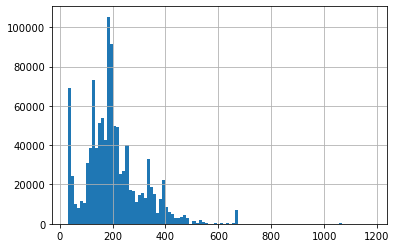

In [152]:
all_df['uid1_TransactionAmt_std'].hist(bins=100)

In [157]:
res = power_transform(all_df['uid1_TransactionAmt_std'].values.reshape(-1, 1))

In [165]:
mask = all_df[numeric_features].dtypes != 'O'

In [170]:
numeric_final = np.array(numeric_features)[mask]

In [ ]:
%%time
res = power_transform(all_df[numeric_final], method='yeo-johnson')

In [154]:
skew(all_df['uid1_TransactionAmt_std'], nan_policy='omit')

masked_array(data=1.18028934,
             mask=False,
       fill_value=1e+20)

In [150]:
numeric_features

['uid5_TransactionAmt_mean',
 'dayofmonth_freq',
 'V15',
 'V118',
 'V329',
 'V282',
 'card_and_subcard_TransactionAmt_mean',
 'V159',
 'V38',
 'V242',
 'V43',
 'V276',
 'V10',
 'D10',
 'V298',
 'uid1_TransactionAmt_std',
 'C2',
 'V305',
 'V32',
 'V46',
 'V165',
 'uid1_TransactionAmt_mean',
 'V252',
 'V234',
 'M7_freq',
 'V220',
 'id_27_freq',
 'id_15_freq',
 'V307',
 'V94',
 'V254',
 'id_08',
 'V171',
 'V337',
 'V86',
 'V154',
 'V205',
 'V327',
 'dist1',
 'V79',
 'V325',
 'uid2_C13_std',
 'V64',
 'V80',
 'id_14_freq',
 'V77',
 'V169',
 'card5_freq',
 'uid1_C13_std',
 'V321',
 'V90',
 'V151',
 'V37',
 'card_and_subcard_D15_std',
 'V65',
 'dollars_freq',
 'C13',
 'D15',
 'V185',
 'V189',
 'V53',
 'V172',
 'V157',
 'V41',
 'V144',
 'V68',
 'id_19_freq',
 'V49',
 'V310',
 'id_37_freq',
 'V166',
 'V338',
 'V48',
 'M_sum',
 'uid4_TransactionAmt_mean',
 'V256',
 'V110',
 'V29',
 'V180',
 'id_04',
 'C11',
 'V186',
 'V143',
 'V292',
 'V230',
 'V253',
 'V36',
 'VersionNum',
 'V279',
 'V12',
 'ad

# Splits

In [113]:
train_final = all_df[:N_TRAIN_EXAMPLES]
test_final = all_df[N_TRAIN_EXAMPLES:]

tr = train_final[:N_TRAIN]
val = train_final[N_TRAIN:]

In [114]:
def downsample(df, how_strong=2):
    positive = df[df.isFraud == 1]
    negative = df[df.isFraud == 0]
    negative = negative.sample(int(len(negative) / how_strong))
    res = pd.concat([positive, negative])
    return res.sample(len(res))

In [212]:
tr = downsample(tr, 5)
val = downsample(val, 5)

In [96]:
values_normalization(all_df, 'day', 'subcard_reg_timestamp')

# Train

In [115]:
add_cols = [col + '_day_min_max' for col in d_cols] 
add_cols = add_cols + [col + '_day_std_score' for col in d_cols]

In [116]:
from IEEE_FRAUD.settings import CATEGORICAL_FEATURES as roman_categorical

In [117]:
import pickle

In [118]:
with open('col_names_sunday.pkl', 'wb') as f:
    pickle.dump((MODEL_FEATURES, CATEGORICAL_FEATURES, roman_feature_names, roman_categorical, add_cols), f)

In [119]:
MODEL_FEATURES.add('subcard_reg_timestamp_day_min_max')

In [120]:
roman_categorical = list(set(roman_categorical) - set(['is_holiday']))

In [121]:
good_cols = list(MODEL_FEATURES - set(['VersionNum']) - set(['card1']) -\
                    set(d_cols)) + add_cols
good_categotical = list(set(CATEGORICAL_FEATURES) - set(['card1']))

In [122]:
all_good_features = set(good_cols +\
                            ['subcard_reg_timestamp_day_min_max',
                             ] + list(roman_feature_names)) -\
    set(['card1', 'dayofmonth'])
all_good_categorical = set(good_categotical + roman_categorical) - set(['card1', 'is_holiday', 'dayofmonth'])

In [123]:
dtrain = lgb.Dataset(tr[all_good_features], label=tr['isFraud'],
                     categorical_feature=all_good_categorical,free_raw_data=False)
dval = lgb.Dataset(val[all_good_features], label=val['isFraud'],
                   categorical_feature=all_good_categorical, free_raw_data=False)

In [124]:
params = {'num_leaves': 200,
          'min_child_samples': 40,
          #'min_sum_hessian_in_leaf': 5e-3,
          #'max_bin': 1023,
          #'min_data_in_leaf': 
          #'scale_pos_weight': 2,
          'objective': 'binary',
          'metric': 'auc',
          'max_depth': 13,
          'learning_rate': 0.01,
          "boosting_type": "goss",
          "top_rate": 0.6,
          "other_rate": 0.1,
          "bagging_freq": 0,
          'nthread': 16,
          
          'pos_bagging_fraction': 0.8,
          'neg_bagging_fraction': 0.01,
          "bagging_fraction": 0.5,
          "bagging_seed": 11,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          
          'feature_fraction': 0.9,
          'min_data_per_group': 25,
          'cat_smooth': 500,
          'max_cat_to_onehot': 8
          #'categorical_feature': cat_cols
         }

In [125]:
%%time
model = lgb.train(params, dtrain, num_boost_round=10000,
                  valid_sets=(dval, dtrain), valid_names=('val', 'train'),
                early_stopping_rounds=25, verbose_eval=100)

Training until validation scores don't improve for 25 rounds.
[100]	train's auc: 0.944835	val's auc: 0.902119
[200]	train's auc: 0.96959	val's auc: 0.919802
[300]	train's auc: 0.98095	val's auc: 0.928076
[400]	train's auc: 0.987938	val's auc: 0.933185
[500]	train's auc: 0.992262	val's auc: 0.937322
[600]	train's auc: 0.995183	val's auc: 0.940466
[700]	train's auc: 0.996966	val's auc: 0.942374
[800]	train's auc: 0.998149	val's auc: 0.944051
[900]	train's auc: 0.998844	val's auc: 0.945225
[1000]	train's auc: 0.999284	val's auc: 0.946037
[1100]	train's auc: 0.999572	val's auc: 0.946852
[1200]	train's auc: 0.999751	val's auc: 0.947426
[1300]	train's auc: 0.999856	val's auc: 0.947971
[1400]	train's auc: 0.999919	val's auc: 0.948361
[1500]	train's auc: 0.999955	val's auc: 0.948664
[1700]	train's auc: 0.999988	val's auc: 0.949173
[1800]	train's auc: 0.999995	val's auc: 0.949525
[1900]	train's auc: 0.999998	val's auc: 0.949825
[2000]	train's auc: 0.999999	val's auc: 0.9502
[2100]	train's auc: 

In [ ]:
0.947236

In [ ]:
0.947028 0.946727 0.946764

In [ ]:
%%time
model = lgb.train(params, dtrain, num_boost_round=10000,
                  valid_sets=(dval, dtrain), valid_names=('val', 'train'),
                early_stopping_rounds=25, verbose_eval=25)

# Split importance

In [126]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance('split'), good_cols)), columns=['Value','Feature'])
bad_cols = feature_imp[feature_imp['Value'] < 1]['Feature']
len(bad_cols)

65

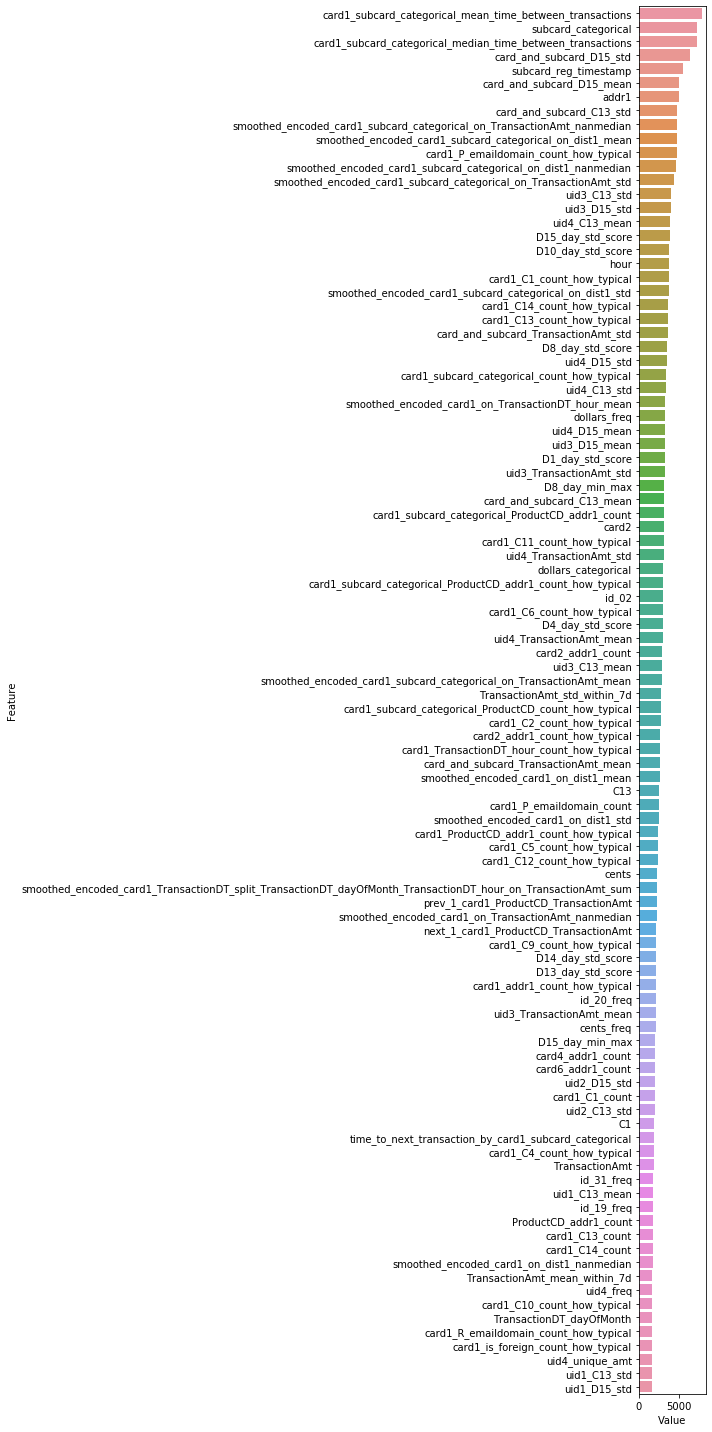

In [127]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance('split'), all_good_features)), columns=['Value','Feature'])
bad_cols = feature_imp[feature_imp['Value'] < 1]['Feature']
plt.figure(figsize=(10, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:100])
plt.tight_layout()
plt.show()

# SHAP importance

In [128]:
shap_test = test_final.sample(10000)

In [ ]:
shap_imp[shap_imp['Feature'] == 'cents_freq']

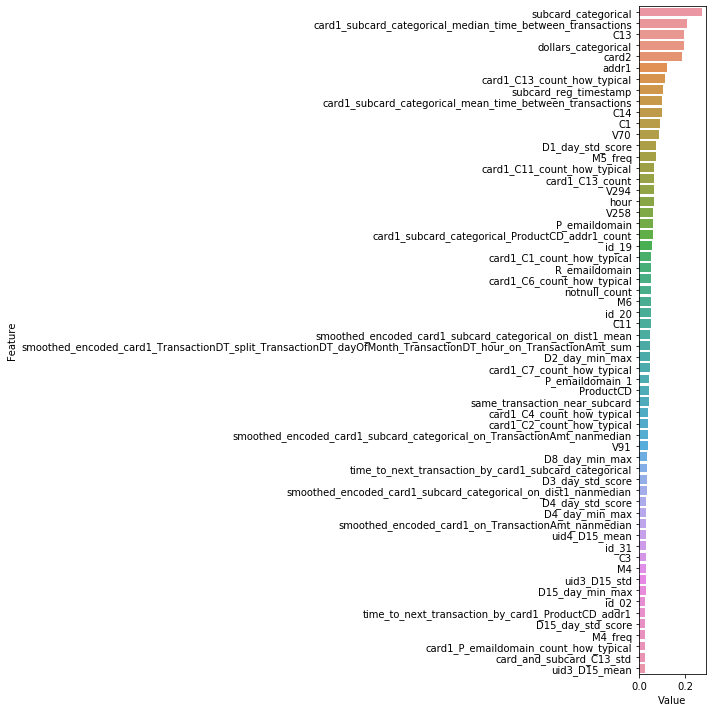

CPU times: user 1h 39min 14s, sys: 4.34 s, total: 1h 39min 19s
Wall time: 6min 22s


In [129]:
%%time
res = model.predict(shap_test[all_good_features], pred_contrib=True)
mean_shap = np.abs(res).mean(axis=0)
shap_imp = pd.DataFrame(sorted(zip(mean_shap, all_good_features)), columns=['Value','Feature'])
plt.figure(figsize=(10, 10))
sns.barplot(x="Value", y="Feature", data=shap_imp.sort_values(by="Value", ascending=False)[:60])
plt.tight_layout()
plt.show()

# Fit KFold (Scary)

In [130]:
from sklearn.model_selection import GroupKFold

In [131]:
gkf = GroupKFold(6)

In [132]:
params = {'num_leaves': 200,
          'min_child_samples': 40,
          #'min_sum_hessian_in_leaf': 5e-3,
          #'max_bin': 1023,
          #'min_data_in_leaf': 
          #'scale_pos_weight': 2,
          'objective': 'binary',
          'metric': 'auc',
          'max_depth': 13,
          'learning_rate': 0.007,
          "boosting_type": "goss",
          "top_rate": 0.6,
          "other_rate": 0.1,
          "bagging_freq": 0,
          'nthread': 16,
          
          'pos_bagging_fraction': 0.8,
          'neg_bagging_fraction': 0.01,
          "bagging_fraction": 0.5,
          "bagging_seed": 11,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          
          'feature_fraction': 0.9,
          'min_data_per_group': 25,
          'cat_smooth': 500,
          'max_cat_to_onehot': 8
          #'categorical_feature': cat_cols
         }

In [133]:
import gc

In [134]:
del dtrain, dval

In [135]:
gc.collect()

36012

In [136]:
scores = []
all_preds = []
for train_ids, val_ids in gkf.split(train_final, train_final['isFraud'], train_final['DT_split']):
    df_tr = train_final.loc[train_ids]
    df_val = train_final.loc[val_ids]
    dtrain = lgb.Dataset(df_tr[all_good_features], label=df_tr['isFraud'],
                         categorical_feature=all_good_categorical, free_raw_data=False)
    dval = lgb.Dataset(df_val[all_good_features], label=df_val['isFraud'],
                       categorical_feature=all_good_categorical, free_raw_data=False)
    
    
    model = lgb.train(params, dtrain, num_boost_round=10000, valid_sets=(dval),
                early_stopping_rounds=100, verbose_eval=100)
    preds = model.predict(test_final[all_good_features], num_iteration=model.best_iteration)
    
    all_preds.append(preds)
    scores.append(model.best_score)

/home/a_tishurov/.conda/envs/experiments/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/a_tishurov/.conda/envs/experiments/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.874773
[200]	valid_0's auc: 0.890246
[300]	valid_0's auc: 0.898797
[400]	valid_0's auc: 0.904722
[500]	valid_0's auc: 0.9085
[600]	valid_0's auc: 0.911662
[700]	valid_0's auc: 0.914021
[800]	valid_0's auc: 0.916415
[900]	valid_0's auc: 0.918578
[1000]	valid_0's auc: 0.920177
[1100]	valid_0's auc: 0.921388
[1200]	valid_0's auc: 0.922167
[1300]	valid_0's auc: 0.923161
[1400]	valid_0's auc: 0.924104
[1500]	valid_0's auc: 0.924863
[1600]	valid_0's auc: 0.925643
[1700]	valid_0's auc: 0.926122
[1800]	valid_0's auc: 0.926505
[1900]	valid_0's auc: 0.927156
[2000]	valid_0's auc: 0.92752
[2100]	valid_0's auc: 0.927948
[2400]	valid_0's auc: 0.928738
[2500]	valid_0's auc: 0.928909
[2600]	valid_0's auc: 0.929149
[2700]	valid_0's auc: 0.929391
[2800]	valid_0's auc: 0.929418
[2900]	valid_0's auc: 0.929395
[3000]	valid_0's auc: 0.929569
[3100]	valid_0's auc: 0.929675
[3200]	valid_0's auc: 0.929731
[3300]	valid_0's au

[2900]	valid_0's auc: 0.966343
[3000]	valid_0's auc: 0.966448
[3100]	valid_0's auc: 0.966579
[3200]	valid_0's auc: 0.966714
[3300]	valid_0's auc: 0.966831
[3400]	valid_0's auc: 0.966975
[3500]	valid_0's auc: 0.967077
[3600]	valid_0's auc: 0.96713
[3700]	valid_0's auc: 0.967195
[3800]	valid_0's auc: 0.967224
Early stopping, best iteration is:
[3789]	valid_0's auc: 0.967238


In [137]:
scores

[defaultdict(dict, {'valid_0': {'auc': 0.93123729947995}}),
 defaultdict(dict, {'valid_0': {'auc': 0.9587183492203231}}),
 defaultdict(dict, {'valid_0': {'auc': 0.9635447724934437}}),
 defaultdict(dict, {'valid_0': {'auc': 0.9518483896890105}}),
 defaultdict(dict, {'valid_0': {'auc': 0.9599709559599323}}),
 defaultdict(dict, {'valid_0': {'auc': 0.9672375021587746}})]

In [138]:
[score['valid_0']['auc'] for score in scores]

[0.93123729947995,
 0.9587183492203231,
 0.9635447724934437,
 0.9518483896890105,
 0.9599709559599323,
 0.9672375021587746]

In [139]:
best_score = np.mean([score['valid_0']['auc'] for score in scores])

In [140]:
best_score

0.9554262115002391

In [141]:
from scipy.stats import gmean

In [142]:
from scipy.stats import gmean
gmean_preds = gmean(all_preds, axis=0)
np.corrcoef(gmean_preds, np.mean(all_preds, axis=0))

array([[1.        , 0.99931604],
       [0.99931604, 1.        ]])

# Fit all (Optional)

In [245]:
dfinal = lgb.Dataset(train_final[all_good_features], label=train_final['isFraud'],
                     categorical_feature=all_good_categorical, free_raw_data=False)

In [246]:
%%time
model_all = lgb.train(params, dtrain,
                      num_boost_round=4000,
                      verbose_eval=50)

/home/a_tishurov/.conda/envs/experiments/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


CPU times: user 6h 50min 48s, sys: 5min 10s, total: 6h 55min 59s
Wall time: 27min 26s


# Predict

In [248]:
%%time
preds = model_all.predict(test_final[good_cols], num_iteration=model.best_iteration)

CPU times: user 7min 48s, sys: 21.3 s, total: 8min 10s
Wall time: 57.8 s


In [143]:
sub = pd.read_csv('data/sample_submission.csv')
sub['isFraud'] = gmean_preds
sub.to_csv(f'submissions/gkfold_add_subgroup_features{best_score:0.7}.csv.gz', index=False)

In [ ]:
f'submissions/kfold_without_te_12_folds{best_score:0.4}.csv.gz'

In [ ]:
sub2 = pd.read_csv('submissions/gkfold_d_min_max_0.94122.csv.gz')

In [ ]:
np.corrcoef(sub.isFraud, sub2.isFraud)

# Permutation Importance

# Adversarial

In [ ]:
all_df['is_test'] = [0 for _ in range(len(train))] + [1 for _ in range(len(test))]

In [ ]:
adv_df = all_df.sample(100000)

In [ ]:
good_cols = list(MODEL_FEATURES - set(['VersionNum'])) #- set(baaad))# -\
#                 set(['BrowserVersion', 'V9', 'id_31', 'id_13']))
good_categotical = list(set(CATEGORICAL_FEATURES))# - set(baaad))# -\
#                        set([ 'BrowserVersion', 'id_31', 'id_13']))\

In [ ]:
d_adv = lgb.Dataset(adv_df[good_cols], label=adv_df['is_test'], categorical_feature=good_categotical,
                    free_raw_data=False)

In [ ]:
adv_model = lgb.train(params, d_adv,
                      num_boost_round=60,
                      verbose_eval=10)

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
pred = adv_model.predict(adv_df[good_cols])

In [ ]:
roc_auc_score(adv_df['is_test'], pred)

In [ ]:
['card1', 'card2', 'BrowserVersion', 'V9', 'id_31', 'id_13']
baaad = ['id_13_freq', 'D15', 'dist1', 'D11', 'dayofmonth',
         'D10', 'BrowserVersion_freq', 'id_31_freq',
         'dayofmonth_freq', 'D4', 'C12', 'V326', 'id_38',
         'M_na', 'V335', 'id_38_freq', 'V8', 'M9_freq', 'id_01', 'id_34', 'Browser',
         'id_34_freq', 'OSMajorVersion', 'OSMajorVersion_freq','card5', 'id_32', 'id_30_freq', 'id_33_freq'] +\
        [f for f in all_df.columns if f.startswith('D') and len(f) <= 3] +\
        [f for f in all_df.columns if f.startswith('V') and len(f) <= 4] +\
        [f for f in all_df.columns if f.startswith('C') and len(f) <= 4] +\
        [f for f in all_df.columns if f.startswith('id_')
         or f.startswith('uid') or f.startswith('addr')] +\
        [f for f in all_df.columns if f.startswith('M') and (len(f) <= 4 or f.endswith('freq'))]

In [ ]:
train['id_32'].hist()

In [ ]:
test['id_32'].hist()

In [ ]:
all_df[:len(train)]['V8'].hist()

In [ ]:
all_df[len(train):]['V8'].hist()

In [ ]:
len(good_cols)

In [ ]:
all_df['BrowserVersion'].value_counts()

In [ ]:
%%time
sample = adv_df.sample(5000)
res = adv_model.predict(sample[good_cols], pred_contrib=True)
mean_shap = np.abs(res).mean(axis=0)
shap_imp = pd.DataFrame(sorted(zip(mean_shap, good_cols)), columns=['Value','Feature'])
plt.figure(figsize=(10, 10))
sns.barplot(x="Value", y="Feature", data=shap_imp.sort_values(by="Value", ascending=False)[:60])
plt.tight_layout()
plt.show()

In [ ]:
from eli5.sklearn import PermutationImportance

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
lgb_clf = LGBMClassifier(**params)

In [ ]:
%%time
lgb_clf.fit(tr[good_cols].fillna(-1), tr['isFraud'], feature_name=good_cols, categorical_feature=good_categotical)

In [ ]:
imp = PermutationImportance(lgb_clf, 'roc_auc', refit=False)

In [ ]:
%%time
res = imp.fit(val[good_cols].fillna(-1), val['isFraud'])

# PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
C_cols = [col for col in all_df.columns if col.startswith('C') and len(col) < 4]

In [ ]:
C_pca = PCA(n_components=0.99).fit_transform(all_df[C_cols].fillna(0))

In [ ]:
C_pca[:, 0].shape

In [ ]:
pca_cols = []
for i, col in enumerate([f'C_PCA_{c}' for c in range(C_pca.shape[1])]):
    all_df[col] = C_pca[:, i]
    pca_cols.append(col)
    

In [ ]:
MODEL_FEATURES.update(pca_cols)

In [ ]:
V_cols = [col for col in all_df.columns if col.startswith('V') and len(col) < 5]

In [ ]:
%%time
V_pca = PCA(n_components=0.99).fit_transform(all_df[V_cols].fillna(0))

In [ ]:
v_pca_cols = []
for i, col in enumerate([f'V_PCA_{c}' for c in range(V_pca.shape[1])]):
    all_df[col] = V_pca[:, i]
    v_pca_cols.append(col)
    

In [ ]:
MODEL_FEATURES.update(v_pca_cols)

In [ ]:
diff_cols = []
d_cols = [col for col in all_df.columns if col.startswith('D') and len(col) < 3 and col != 'DT']
for col in d_cols:
    all_df[col + '_diff'] = all_df[col].diff()
    diff_cols.append(col + '_diff')

In [ ]:
g = ['id_33_freq', 'V143', 'id_11', 'id_20_freq', 'V123', 'V323', 'V267', 'uid5_D15_std', 'V269', 'id_24', 'V212', 'V234', 'uid2_D15_std', 'V24', 'V259', 'V316', 'V12', 'V334', 'V115', 'V261', 'V77', 'M6', 'C8', 'V57', 'uid3_D15_std', 'V92', 'id_28', 'V67', 'V34', 'R_emaildomain_2', 'V228', 'C12', 'V4', 'V328', 'V248', 'DeviceType_freq', 'C6', 'V294', 'V106', 'V265', 'id_12_freq', 'V139', 'V250', 'V258', 'V39', 'V18', 'V32', 'V48', 'id_08', 'addr1', 'V80', 'id_02', 'V320', 'M6_freq', 'id_23', 'uid5_TransactionAmt_std', 'OSMajorVersion_freq', 'V111', 'V10', 'P_emaildomain_1_freq', 'V225', 'R_emaildomain_3_freq', 'V199', 'D9', 'V244', 'M7', 'V50', 'OSMajorVersion', 'id_12', 'id_37_freq', 'V313', 'V101', 'id_38', 'V231', 'V216', 'V186', 'V220', 'V293', 'V55', 'uid3_freq', 'V170', 'V84', 'V98', 'V140', 'V256', 'DeviceInfoMajor', 'id_32_freq', 'V181', 'id_25_freq', 'V284', 'V29', 'V58', 'R_emaildomain_1', 'addr2_freq', 'V301', 'id_18', 'dayofmonth_freq', 'V63', 'V298', 'V289', 'V281', 'V255', 'M_na', 'V292', 'M3_freq', 'uid2_D15_mean', 'D12_day_min_max', 'V81', 'V300', 'dayofweek_freq', 'V270', 'uid4_TransactionAmt_std', 'V15', 'V175', 'id_32', 'id_19', 'V69', 'V178', 'V36', 'V260', 'V242', 'D14_day_min_max', 'V251', 'V20', 'DeviceInfo', 'V224', 'V86', 'id_37', 'id_35_freq', 'V156', 'V276', 'V303', 'addr1_freq', 'V253', 'V168', 'V335', 'V132', 'V79', 'V266', 'id_15_freq', 'V208', 'V108', 'V90', 'V185', 'V91', 'decimal_len', 'R_emaildomain_1_freq', 'P_emaildomain_2_freq', 'V133', 'V167', 'C7', 'id_10', 'V271', 'V213', 'V198', 'id_05', 'DeviceInfo_freq', 'V94', 'V126', 'M8_freq', 'V46', 'id_17', 'V155', 'V262', 'id_01', 'V53', 'V273', 'uid4_D15_mean', 'M4', 'V17', 'id_22', 'V286', 'V200', 'V246', 'id_17_freq', 'C10', 'M8', 'id_31_freq', 'V161', 'card5', 'V218', 'V26', 'V162', 'V338', 'V307', 'R_emaildomain', 'V5', 'decimal_value_freq', 'uid3_D15_mean', 'uid5_C13_mean', 'id_16_freq', 'V254', 'is_holiday_freq', 'V183', 'P_emaildomain_2', 'V76', 'P_emaildomain', 'V188', 'V195', 'V124', 'V75', 'dayofmonth', 'V95', 'D6_day_min_max', 'V35', 'V308', 'uid2_unique_amt', 'id_30', 'V336', 'V193', 'R_emaildomain_2_freq', 'V2', 'V127', 'uid4_freq', 'V45', 'V33', 'M1', 'uid2_TransactionAmt_std', 'weekofmonth', 'V73', 'id_28_freq', 'C1', 'V99', 'DeviceInfoTop', 'V243', 'V215', 'V104', 'uid4_C13_mean', 'card4_freq', 'id_34', 'V222', 'dist2', 'V83', 'M9', 'V49', 'OSName_freq', 'M3', 'V169', 'id_30_freq', 'V235', 'V311', 'D7_day_min_max', 'V205', 'V103', 'V209', 'V203', 'id_36', 'V149', 'D11_day_min_max', 'V290', 'V166', 'M9_freq', 'V236', 'V112', 'id_19_freq', 'V116', 'V31', 'id_14', 'V291', 'uid5_TransactionAmt_mean', 'id_38_freq', 'C13', 'V56', 'IsMobile_freq', 'V330', 'V85', 'V128', 'V152', 'id_36_freq', 'V11', 'V22', 'uid1_TransactionAmt_mean', 'V304', 'M5_freq', 'V25', 'V190', 'card4', 'V54', 'V109', 'P_emaildomain_1', 'id_13', 'Browser_freq', 'V43', 'V202', 'is_holiday', 'V174', 'V191', 'V219', 'V277', 'id_20', 'V23', 'id_23_freq', 'V142', 'id_09', 'D4_day_min_max', 'V157', 'V146', 'V275', 'Browser', 'V135', 'id_31', 'V263', 'V9', 'P_emaildomain_freq', 'V221', 'uid1_D15_mean', 'C5', 'V288', 'C3', 'V37', 'V187', 'D3_day_min_max', 'V165', 'V296', 'V72', 'V299', 'card3_freq', 'V147', 'D2_day_min_max', 'V272', 'V171', 'V52', 'V38', 'uid2_freq', 'V138', 'V238', 'ProductCD_freq', 'V110', 'D8_day_min_max', 'card6_freq', 'id_15', 'V264', 'C9', 'V322', 'uid1_freq', 'uid2_C13_mean', 'id_13_freq', 'V283', 'V237', 'V159', 'V227', 'V19', 'V62', 'V130', 'id_06', 'V207', 'R_emaildomain_3', 'uid4_D15_std', 'V47', 'V158', 'V282', 'V180', 'V102', 'V154', 'V206', 'V339', 'uid5_unique_amt', 'V229', 'IsMobile', 'uid4_unique_amt', 'V136', 'V100', 'uid1_C13_std', 'V177', 'V66', 'uid1_unique_amt', 'V201', 'V105', 'TransactionAmt', 'V214', 'id_07', 'V257', 'V332', 'V319', 'M4_freq', 'V114', 'C14', 'V134', 'V249', 'id_14_freq', 'V8', 'V51', 'D13_day_min_max', 'card6', 'V315', 'hour_freq', 'V245', 'V61', 'V268', 'V239', 'DeviceInfoMajor_freq', 'DeviceInfoTop_freq', 'V42', 'V148', 'V297', 'V192', 'dayofweek', 'V247', 'V204', 'id_24_freq', 'C11', 'V196', 'uid5_freq', 'V223', 'uid1_C13_mean', 'card2_freq', 'V78', 'V64', 'V295', 'uid1_D15_std', 'V172', 'V333', 'uid4_TransactionAmt_mean', 'V194', 'id_16', 'V280', 'V232', 'uid3_C13_std', 'V189', 'V324', 'V176', 'V321', 'D10_day_min_max', 'V70', 'V306', 'ProductCD', 'card5_freq', 'V60', 'V164', 'V151', 'V44', 'V337', 'V326', 'V13', 'V331', 'V317', 'V30', 'V278', 'OSName', 'id_34_freq', 'id_03', 'card1_freq', 'V7', 'V121', 'uid3_TransactionAmt_mean', 'V71', 'V226', 'M2', 'V302', 'uid3_unique_amt', 'card3', 'V217', 'V150', 'V96', 'V40', 'C2', 'weekofmonth_freq', 'V184', 'C4', 'M5', 'V145', 'V309', 'V173', 'uid5_D15_mean', 'V137', 'V210', 'decimal_value', 'uid5_C13_std', 'V182', 'V87', 'D1_day_min_max', 'V125', 'V252', 'V287', 'V160', 'D15_day_min_max', 'V211', 'V310', 'uid2_C13_std', 'id_26_freq', 'M7_freq', 'V163', 'V312', 'uid1_TransactionAmt_std', 'V131', 'V329', 'R_emaildomain_freq', 'uid2_TransactionAmt_mean', 'V285', 'V274', 'V129', 'V230', 'V74', 'uid4_C13_std', 'V279', 'V3', 'V59', 'dist1', 'uid3_C13_mean', 'V82', 'uid3_TransactionAmt_std', 'V233', 'id_33', 'V144', 'M2_freq', 'V197', 'id_18_freq', 'V153', 'V6', 'V314', 'V97', 'V318', 'V179', 'id_04', 'id_21_freq', 'D5_day_min_max', 'DeviceType', 'V93']

In [ ]:
len(g)